In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as datasets

import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import Resize
from torch.utils.data import DataLoader, Subset

import torch.optim as optim

In [2]:
# define cnn model 
class cnn_autoencoder(nn.Module):
    def __init__(self):
        super(cnn_autoencoder, self).__init__()
        
        self.act = nn.ReLU()
        self.flat = nn.Flatten()
        self.sig = nn.Sigmoid()

        self.c1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.c2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.c3 = nn.Conv2d(32, 64, 7)

        self.t1 = nn.ConvTranspose2d(64, 32, 7)
        self.t2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.t3 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)

    def forward(self, image):
        # encode image
        img = self.act(self.c1(image))
        img = self.act(self.c2(img))
        img = self.flat(self.c3(img))

        # decode image
        img = img.view(-1, 64, 1, 1)
        img = self.act(self.t1(img))
        img = self.act(self.t2(img))
        img = self.sig(self.t3(img))
        
        return img

In [3]:
# configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARN_RATE = 1e-4

In [4]:
# load data
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 182110789.99it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 68130311.49it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44586436.88it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7914635.97it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
# get data subsets
# get indicies of 5, 6, 8, 9
idx5 = [i for i, (_, label) in enumerate(dataset) if label == 5]
idx6 = [i for i, (_, label) in enumerate(dataset) if label == 6]
idx8 = [i for i, (_, label) in enumerate(dataset) if label == 8]
idx9 = [i for i, (_, label) in enumerate(dataset) if label == 9]

# create dataloaders for training autoencoders
five_loader = DataLoader(dataset=Subset(dataset, idx5[:-100]), batch_size=BATCH_SIZE, shuffle=True)
six_loader = DataLoader(dataset=Subset(dataset, idx6[:-100]), batch_size=BATCH_SIZE, shuffle=True)
eight_loader = DataLoader(dataset=Subset(dataset, idx8[:-100]), batch_size=BATCH_SIZE, shuffle=True)
nine_loader = DataLoader(dataset=Subset(dataset, idx9[:-100]), batch_size=BATCH_SIZE, shuffle=True)

# create dataloader for clustering
idx5689 = np.hstack([idx5[-100:], idx6[-100:], idx8[-100:], idx9[-100:]])
print(len(idx5689))
test5689_loader = DataLoader(dataset=Subset(dataset, idx5689), batch_size=BATCH_SIZE, shuffle=False)

400


In [6]:
cnnmodel = cnn_autoencoder().to(DEVICE)
optimizer = optim.Adam(cnnmodel.parameters(), lr=LEARN_RATE)
loss_func = nn.MSELoss()

In [7]:
# cnn training loop
outputs = []
for epoch in range(NUM_EPOCHS):
    for i, (x, _) in enumerate(five_loader):
        # forward
        x = x.to(DEVICE)
        reconstructed_x = cnnmodel(x)
#         print(reconstructed_x.shape)
        
        # compute loss
        loss = loss_func(reconstructed_x, x)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 5 == 0:    
        print(f'epoch: {epoch}, loss: {loss.item():.4f}')
    outputs.append((epoch, x, reconstructed_x))
    

epoch: 0, loss: 0.1314
epoch: 5, loss: 0.0650
epoch: 10, loss: 0.0523
epoch: 15, loss: 0.0601
epoch: 20, loss: 0.0529
epoch: 25, loss: 0.0449
epoch: 30, loss: 0.0279
epoch: 35, loss: 0.0176
epoch: 40, loss: 0.0142
epoch: 45, loss: 0.0119


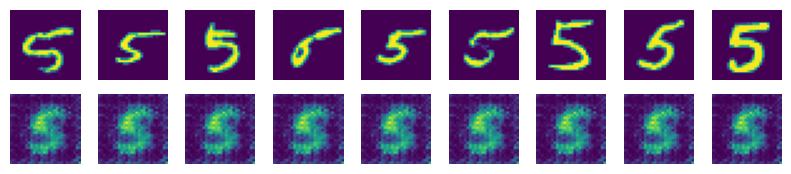

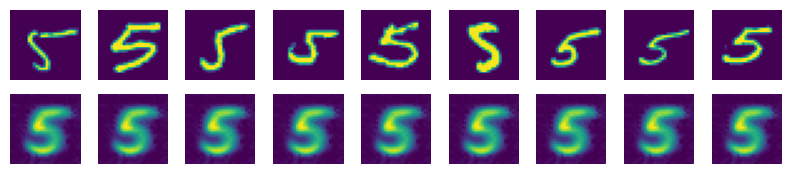

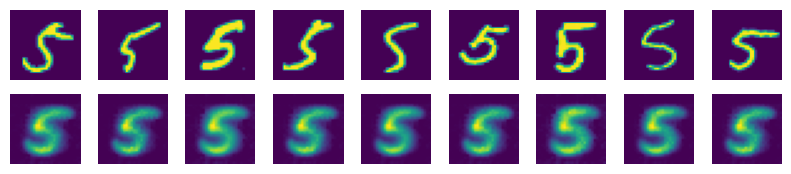

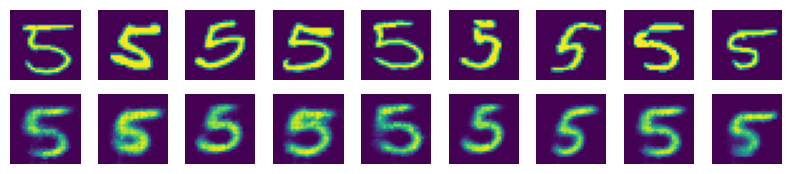

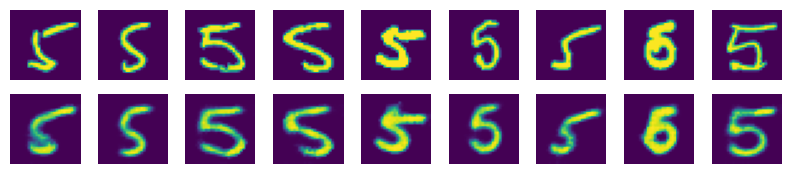

In [8]:
# cnn plot
for epoch in range(1, NUM_EPOCHS, 10):
    # get images
    imgs = outputs[epoch][1].cpu().detach().numpy()
    recon = outputs[epoch][2].cpu().detach().numpy()
    # num images to plot
    if imgs.shape[0] >= 10:
        cols = 10
    else:
        cols = imgs.shape[0]
    # plot    
    fig, ax = plt.subplots(2, cols, figsize=(10,2))
    axs = ax.ravel()
    for i in range(cols):
        axs[i].imshow(imgs[i][0])
        axs[i].axis('off')
        axs[i + cols].imshow(recon[i][0])
        axs[i+cols].axis('off')